# ASL Recognition Model Training
## Using MediaPipe Landmarks for Alphabet and Number Classification

In [1]:
import pickle
import numpy as np
import cv2
import mediapipe as mp
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

I0000 00:00:1752024605.365248  132914 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752024605.374460  133270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752024605.382043  133274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
def extract_landmarks(image_path):
    """Extract hand landmarks from an image"""
    try:
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            return None
        
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process image with MediaPipe
        results = hands.process(image_rgb)
        
        if results.multi_hand_landmarks:
            # Get landmarks from the first detected hand
            landmarks = results.multi_hand_landmarks[0]
            
            # Extract 3D coordinates (x, y, z) for all 21 landmarks
            landmark_features = []
            for landmark in landmarks.landmark:
                landmark_features.extend([landmark.x, landmark.y, landmark.z])
            
            return np.array(landmark_features)
        else:
            return None
            
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [4]:
def load_dataset(data_path, dataset_type='alphabet'):
    """Load dataset and extract landmarks"""
    features = []
    labels = []
    
    print(f"Loading {dataset_type} dataset...")
    
    # Get all subdirectories (classes)
    classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        print(f"Processing class: {class_name}")
        
        # Get all images in this class
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpeg')]
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            landmarks = extract_landmarks(image_path)
            
            if landmarks is not None:
                features.append(landmarks)
                labels.append(class_name)
        
        print(f"  - {class_name}: {len([f for f in os.listdir(class_path) if f.endswith('.jpeg')])} images processed")
    
    return np.array(features), np.array(labels)

In [5]:
# Load alphabet dataset
print("=== Loading Alphabet Dataset ===")
alphabet_features, alphabet_labels = load_dataset('data/alphabet', 'alphabet')
print(f"Alphabet dataset shape: {alphabet_features.shape}")
print(f"Alphabet labels shape: {alphabet_labels.shape}")
print(f"Unique alphabet classes: {len(np.unique(alphabet_labels))}")
print(f"Alphabet classes: {sorted(np.unique(alphabet_labels))}")

=== Loading Alphabet Dataset ===
Loading alphabet dataset...
Processing class: a
  - a: 70 images processed
Processing class: b
  - b: 70 images processed
Processing class: c
  - c: 70 images processed
Processing class: d
  - d: 70 images processed
Processing class: e
  - e: 70 images processed
Processing class: f
  - f: 70 images processed
Processing class: g
  - g: 70 images processed
Processing class: h
  - h: 70 images processed
Processing class: i
  - i: 70 images processed
Processing class: j
  - j: 70 images processed
Processing class: k
  - k: 70 images processed
Processing class: l
  - l: 70 images processed
Processing class: m
  - m: 70 images processed
Processing class: n
  - n: 70 images processed
Processing class: o
  - o: 70 images processed
Processing class: p
  - p: 70 images processed
Processing class: q
  - q: 70 images processed
Processing class: r
  - r: 70 images processed
Processing class: s
  - s: 70 images processed
Processing class: t
  - t: 65 images processed

In [6]:
# Load number dataset
print("\n=== Loading Number Dataset ===")
number_features, number_labels = load_dataset('data/number', 'number')
print(f"Number dataset shape: {number_features.shape}")
print(f"Number labels shape: {number_labels.shape}")
print(f"Unique number classes: {len(np.unique(number_labels))}")
print(f"Number classes: {sorted(np.unique(number_labels))}")


=== Loading Number Dataset ===
Loading number dataset...
Processing class: 0
  - 0: 70 images processed
Processing class: 1
  - 1: 70 images processed
Processing class: 2
  - 2: 70 images processed
Processing class: 3
  - 3: 70 images processed
Processing class: 4
  - 4: 70 images processed
Processing class: 5
  - 5: 70 images processed
Processing class: 6
  - 6: 70 images processed
Processing class: 7
  - 7: 70 images processed
Processing class: 8
  - 8: 70 images processed
Processing class: 9
  - 9: 70 images processed
Processing class: asl_dataset
  - asl_dataset: 0 images processed
Number dataset shape: (592, 63)
Number labels shape: (592,)
Unique number classes: 10
Number classes: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9')]


In [7]:
# Combine datasets
print("\n=== Combining Datasets ===")
all_features = np.vstack([alphabet_features, number_features])
all_labels = np.concatenate([alphabet_labels, number_labels])

print(f"Combined dataset shape: {all_features.shape}")
print(f"Combined labels shape: {all_labels.shape}")
print(f"Total unique classes: {len(np.unique(all_labels))}")

# Show class distribution
unique_labels, counts = np.unique(all_labels, return_counts=True)
print("\nClass distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")


=== Combining Datasets ===
Combined dataset shape: (1621, 63)
Combined labels shape: (1621,)
Total unique classes: 36

Class distribution:
  0: 29 samples
  1: 60 samples
  2: 49 samples
  3: 68 samples
  4: 69 samples
  5: 70 samples
  6: 51 samples
  7: 65 samples
  8: 61 samples
  9: 70 samples
  a: 15 samples
  b: 65 samples
  c: 33 samples
  d: 66 samples
  e: 22 samples
  f: 68 samples
  g: 53 samples
  h: 46 samples
  i: 53 samples
  j: 13 samples
  k: 67 samples
  l: 68 samples
  m: 8 samples
  n: 11 samples
  o: 15 samples
  p: 48 samples
  q: 13 samples
  r: 52 samples
  s: 12 samples
  t: 1 samples
  u: 63 samples
  v: 52 samples
  w: 49 samples
  x: 47 samples
  y: 35 samples
  z: 54 samples


In [9]:
# Filter out classes with too few samples for stratified split
unique_labels, counts = np.unique(all_labels, return_counts=True)
valid_classes = unique_labels[counts >= 2]  # Keep only classes with 2+ samples

# Filter data to include only valid classes
valid_mask = np.isin(all_labels, valid_classes)
filtered_features = all_features[valid_mask]
filtered_labels = all_labels[valid_mask]

print(f"Filtered dataset shape: {filtered_features.shape}")
print(f"Valid classes: {len(valid_classes)}")

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    filtered_features, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Filtered dataset shape: (1620, 63)
Valid classes: 35
Training set shape: (1296, 63)
Test set shape: (324, 63)
Training labels shape: (1296,)
Test labels shape: (324,)


In [10]:
# Train Random Forest Classifier
print("\n=== Training Model ===")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)
print("Model training completed!")


=== Training Model ===
Model training completed!


In [11]:
# Evaluate model
print("\n=== Model Evaluation ===")
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Accuracy percentage: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


=== Model Evaluation ===
Accuracy: 0.9444
Accuracy percentage: 94.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00        12
           2       0.82      0.90      0.86        10
           3       1.00      1.00      1.00        14
           4       0.88      1.00      0.93        14
           5       1.00      0.86      0.92        14
           6       0.69      0.90      0.78        10
           7       0.92      0.92      0.92        13
           8       0.92      0.92      0.92        12
           9       1.00      1.00      1.00        14
           a       0.67      0.67      0.67         3
           b       1.00      1.00      1.00        13
           c       1.00      1.00      1.00         6
           d       1.00      1.00      1.00        13
           e       0.80      1.00      0.89         4
           f       1.00      1.00      1


=== Feature Importance Analysis ===
Feature importance shape: (63,)


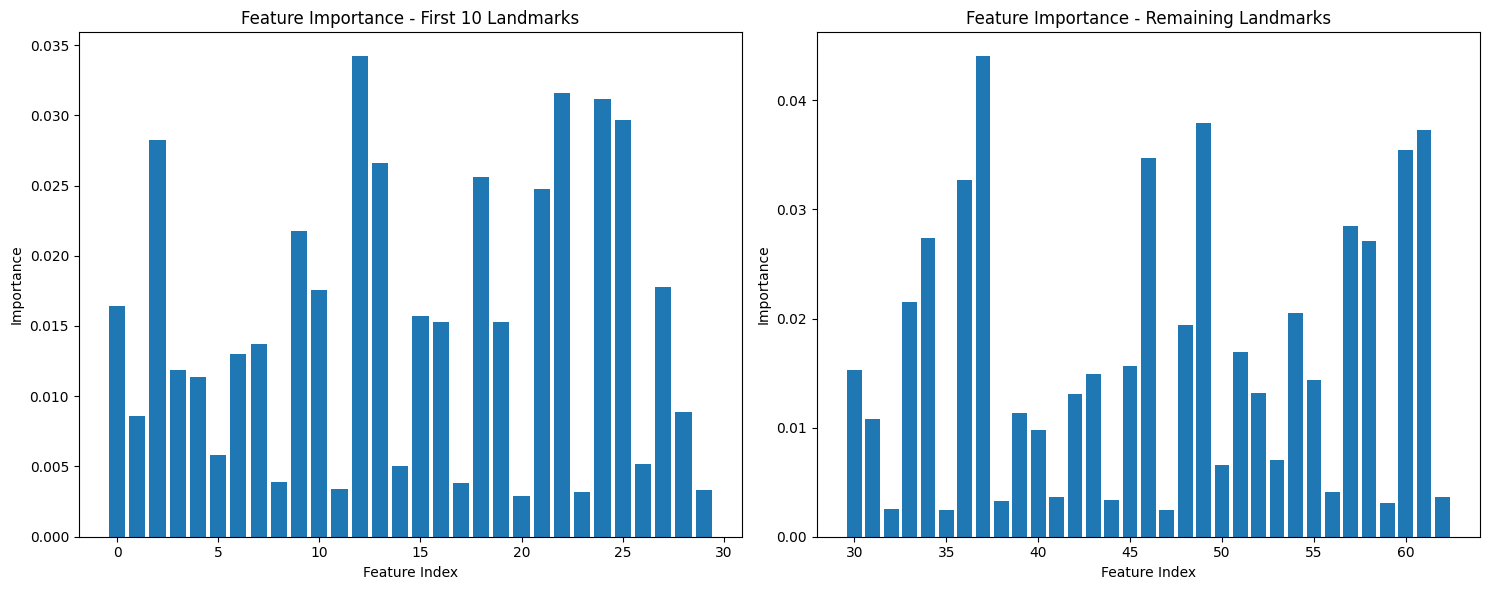

In [12]:
# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = rf_classifier.feature_importances_
print(f"Feature importance shape: {feature_importance.shape}")

# Plot feature importance for first 10 landmarks (30 features: x,y,z for each landmark)
plt.figure(figsize=(15, 6))
landmark_names = [f"Landmark_{i//3}_{['x', 'y', 'z'][i%3]}" for i in range(63)]

plt.subplot(1, 2, 1)
plt.bar(range(30), feature_importance[:30])
plt.title('Feature Importance - First 10 Landmarks')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
plt.bar(range(30, 63), feature_importance[30:])
plt.title('Feature Importance - Remaining Landmarks')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

In [13]:
# Save the model and data
print("\n=== Saving Model and Data ===")

# Save model
with open('asl_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)
print("Model saved as 'asl_model.pkl'")

# Save processed data
data_dict = {
    'features': all_features,
    'labels': all_labels,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_importance': feature_importance
}

with open('asl_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
print("Data saved as 'asl_data.pkl'")

print("\nTraining completed successfully!")


=== Saving Model and Data ===
Model saved as 'asl_model.pkl'
Data saved as 'asl_data.pkl'

Training completed successfully!


In [14]:
# Test prediction function
def predict_asl(image_path, model):
    """Predict ASL sign from an image"""
    landmarks = extract_landmarks(image_path)
    if landmarks is not None:
        prediction = model.predict([landmarks])[0]
        probability = model.predict_proba([landmarks])[0]
        max_prob = np.max(probability)
        return prediction, max_prob
    else:
        return None, None

# Test with a sample image
sample_image = "data/alphabet/a/hand1_a_bot_seg_1_cropped.jpeg"
if os.path.exists(sample_image):
    prediction, confidence = predict_asl(sample_image, rf_classifier)
    print(f"Sample prediction: {prediction} (confidence: {confidence:.4f})")
else:
    print("Sample image not found")

Sample prediction: a (confidence: 0.6304)
